# Spin Qubit Pulse Sequences with the HDAWG

This notebook shows you how to use pulse sequences with an HDAWG to realize various experiments. While the sequences are mostly general, they are adapted to those typically used for spin qubits by adding the gate pulsing to control between Coulomb and spin blockade.

# General Imports

In [4]:
%config IPCompleter.greedy=True

# import matplotlib.pyplot as plt
import numpy as np
import time
import zhinst.core
import laboneq
from laboneq.simple import *
import ctypes
import helpers
import matplotlib.pyplot as plt
from picosdk.ps5000a import ps5000a as ps
from picosdk.functions import adc2mV, assert_pico_ok, mV2adc
import picoscope_module as pm
#install_token("LabOneQ.AllQuantumInOne.")
DO_EMULATION = False # run in emulation mode by default

print(laboneq.__version__)

2.11.0


# Sampling card setup

## Define parameters for experiment

In [5]:
points_map={
    'level1': [0.2, -0.2], #load 02
    'level2': [0, 0], #anchor
    'level3': [-0.2, 0.2], #load 11
    'level4': [-0.2, -0.2], #unload/initilize
}


times_map = {
             'load_time': 20e-3,
             'anchor_time': 5e-3,
             'read_time':20e-3,
             'unload_time': 40e-3, 
             'trigger_time': 1e-3}

## Device Setup

Picoscope and HDAWG

In [6]:
timebase = 628
preTriggerSamples = 10
pico_sampling_rate = (timebase - 3) / 62500000
postTriggerSamples = int(np.ceil(50e-3/pico_sampling_rate)) #Measurment length was 8
TriggerLevel=1

maxSamples = preTriggerSamples + postTriggerSamples
ready = ctypes.c_int16(0)
check = ctypes.c_int16(0)
maxADC = ctypes.c_int16()

chandle, status = pm.initialize_picoscope()
chARange, chBRange, status = pm.setup_channels(chandle)
# find maximum ADC count value

pm.setup_trigger(chandle, chARange, chBRange, maxADC,TriggerLevel)

# Get timebase information

{'maximumValue': 0,
 'setTriggerChannelPropertiesV2': 0,
 'setTriggerChannelConditionsV2': 0,
 'setTriggerChannelDirections': 0}

## Create device setup -HDAWG

In [7]:
descriptor="""
instrument_list:
  HDAWG:
  - address: DEV8721
    uid: device_hdawg
    interface: usb
connections:
  device_hdawg:
    - rf_signal: q0/fg4_line
      ports: [SIGOUTS/0]
    - rf_signal: q0/fg6_line
      ports: [SIGOUTS/1]
"""
#Change back to to SIGOUTS/2 and SIGOUTS/3
#And change fg8 and fg9
device_setup = DeviceSetup.from_descriptor(
    descriptor,
    server_host="127.0.0.1",
    server_port="8004",
    setup_name="ZI_HDAWG",
)

c:\Users\B15measure2\anaconda3\envs\laboneq\lib\site-packages\laboneq\dsl\device\_device_setup_generator.py:1104: FutureWarning: 'instrument_list' section is deprecated in setup descriptor, use 'instruments' instead.
  warnings.warn(


# S-T readout

In [8]:
# define pulse shapes
@pulse_library.register_pulse_functional
def ramp(x,start=0,stop=1 , **_):
    pulse=start+ (stop-start)*(x+1)/2 # Time normalized to (-1,1)
    return pulse



compress_level_pulse_level1_gate1=pulse_library.const(uid="compress_levell1g1",length=times_map['load_time'],amplitude=points_map['level1'][0],can_compress=True)
compress_level_pulse_level1_gate2=pulse_library.const(uid="compress_levell1g2",length=times_map['load_time'],amplitude=points_map['level1'][1],can_compress=True)
compress_level_pulse_level2_gate1=pulse_library.const(uid="compress_levell2g1",length=times_map['anchor_time'],amplitude=points_map['level2'][0],can_compress=True)
compress_level_pulse_level2_gate2=pulse_library.const(uid="compress_levell2g2",length=times_map['anchor_time'],amplitude=points_map['level2'][1],can_compress=True)
compress_level_pulse_level3_gate1=pulse_library.const(uid="compress_levell3g1",length=times_map['read_time'],amplitude=points_map['level3'][0],can_compress=True)
compress_level_pulse_level3_gate2=pulse_library.const(uid="compress_levell3g2",length=times_map['read_time'],amplitude=points_map['level3'][1],can_compress=True)
compress_level_pulse_level4_gate1=pulse_library.const(uid="compress_levell4g1",length=times_map['unload_time'],amplitude=points_map['level4'][0],can_compress=True)
compress_level_pulse_level4_gate2=pulse_library.const(uid="compress_levell4g2",length=times_map['unload_time'],amplitude=points_map['level4'][1],can_compress=True)

In [11]:
## Create Experiment
exp = Experiment(
    "Singlet-triplet qubit example",
    signals=[
        ExperimentSignal("gate1"),
        ExperimentSignal("gate2"),
    ],
)

# define experiment
NUM_REP = 50


with exp.acquire_loop_rt(  #This is no loop, he executes this ones
    uid=("shots"), count=NUM_REP, averaging_mode=AveragingMode.SEQUENTIAL
):
    #with exp.section(
    #     uid="outer_trigger", 
    #     length=times_map['trigger_time'],
    #     alignment=SectionAlignment.LEFT):
    #     exp.reserve(signal="gate3")

    with exp.section(
        uid=("level1"),
        length=times_map['load_time'], 
        trigger={"gate1": {"state": 1}}, 
        alignment=SectionAlignment.LEFT,
    ):
        exp.play(signal="gate1", pulse=compress_level_pulse_level1_gate1)
        exp.play(signal="gate2", pulse=compress_level_pulse_level1_gate2)    
    with exp.section(
        uid=("level2"),
        length=times_map['anchor_time'], 
        alignment=SectionAlignment.LEFT,
    ):
        exp.play(signal="gate1", pulse=compress_level_pulse_level2_gate1)
        exp.play(signal="gate2", pulse=compress_level_pulse_level2_gate2)

    with exp.section(
        uid=("level3"),
        length=times_map['read_time'], 
        alignment=SectionAlignment.LEFT,
    ):
        exp.play(signal="gate1", pulse=compress_level_pulse_level3_gate1)
        exp.play(signal="gate2", pulse=compress_level_pulse_level3_gate2)

    with exp.section(
        uid=("level4"),
        length=times_map['unload_time'], 
        alignment=SectionAlignment.LEFT,
    ):
        exp.play(signal="gate1", pulse=compress_level_pulse_level3_gate1)
        exp.play(signal="gate2", pulse=compress_level_pulse_level3_gate2)

In [12]:
# shortcut to the logical signal group q0
lsg = device_setup.logical_signal_groups["q0"].logical_signals

# define signal map
map_signals = {
    "gate1" : lsg["fg4_line"],
    "gate2" : lsg["fg6_line"]
}

In [13]:
source = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_B"] #set the buffer
noOfCaptures = NUM_REP
status,timeIntervalns = pm.capture_rapid_data_block(chandle, preTriggerSamples, postTriggerSamples, timebase, maxSamples,noOfCaptures)


# # create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=DO_EMULATION)
# set experiment calibration and signal map
exp.set_signal_map(map_signals)



if not session.connection_state.emulated:
    instrument_serial = device_setup.instrument_by_uid("device_hdawg").address
    device = session.devices[instrument_serial]
    device.triggers.out[2].delay(23.9e-9)
print("Loaded exp")
session.run(exp)
print("Running exp finished")
# Check for data collection to finish using ps5000aIsReady
while ready.value == check.value:
    status["isReady"] = ps.ps5000aIsReady(chandle, ctypes.byref(ready))

buffersMax, buffersMin = pm.create_rapid_buffer(chandle, source, maxSamples, noOfCaptures)
pm.getValuesRapid(chandle,maxSamples,noOfCaptures)

2023.08.02 15:56:32.071 laboneq.controller.laboneq_logging INFO   Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is c:\Users\B15measure2\HDAWG\laboneq_output\log
2023.08.02 15:56:32.073 laboneq.controller.controller  INFO   VERSION: laboneq 2.11.0
2023.08.02 15:56:32.077 laboneq.controller.devices.device_collection INFO   Connecting to data server at 127.0.0.1:8004


2023.08.02 15:56:32.326 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.02 at 127.0.0.1:8004
2023.08.02 15:56:32.605 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.08.02 15:56:32.802 laboneq.controller.devices.device_collection INFO   The device setup is configured
Loaded exp
2023.08.02 15:56:33.044 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.08.02 15:56:33.056 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.08.02 15:56:58.334 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 46
2023.08.02 15:56:58.336 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 192
2023.08.02 15:56:58.337 laboneq.compiler.workflow.compiler INFO   Finished LabOne Q Compiler run.
2023.08.02 15:56:58.620 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.08.02 15:56:58.793 laboneq.controller

{'GetValuesBulk': 0}

In [14]:
# convert ADC counts data to mV
cmaxSamples = ctypes.c_int32(maxSamples)

# Create time data
time_stamp=int(time.time())
time_array = np.linspace(0, (cmaxSamples.value - 1) * timeIntervalns.value, cmaxSamples.value)
with open('Data/data_%s.npy'%(time_stamp), 'wb') as f:
    np.save(f,time_array)
    for i in range(noOfCaptures):
        np.save(f,adc2mV(buffersMax[i], chARange, maxADC))
with open('Data/data_%s.txt'%time_stamp, 'w') as f:
    f.write(str(points_map)+'\n')
    f.write(str(times_map)+'\n')
    #f.write(exp)



# display status returns
# print(status)

# Stop the scope
status["stop"] = ps.ps5000aStop(chandle)
assert_pico_ok(status["stop"])


# # Close unit Disconnect the scope
# status["close"]=ps.ps5000aCloseUnit(chandle)
# assert_pico_ok(status["close"])

: 

: 

(-26.977345093132314, 22.68440809350871)

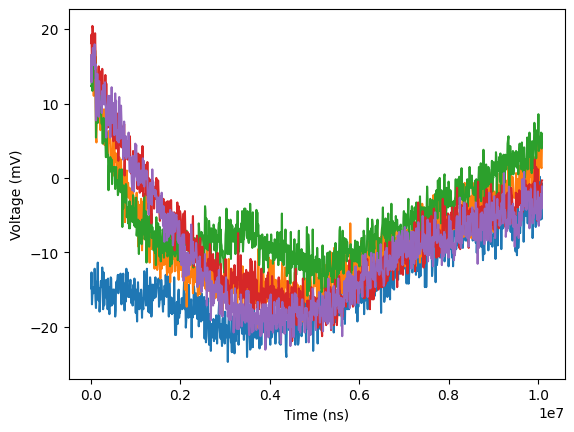

In [10]:
with open('Data/data_%s.npy'%(time_stamp), 'rb') as f:
    time_array=np.load(f)
    plt.plot(time_array, np.load(f)/30)
    plt.plot(time_array,np.load(f)/30)
    plt.plot(time_array,np.load(f)/30)
    plt.plot(time_array,np.load(f)/30)
    plt.plot(time_array,np.load(f)/30)
plt.xlabel('Time (ns)')
plt.ylabel('Voltage (mV)')
plt.ylim()

In [15]:
import time
print(int(time.time()))

1690552004


### View experiment in pulse sheet viewer

To-do: 
1. Add stability diagram visualization

In [10]:
# use pulse sheet viewer to display the pulse sequence - only recommended for small number of averages and sweep steps to avoid performance issues
compiled_exp = session.compiled_experiment
show_pulse_sheet(".\laboneq_output\ST pulse test", compiled_exp)

2023.07.28 15:18:52.558 laboneq.pulse_sheet_viewer.pulse_sheet_viewer INFO   Writing html file to c:\Users\B15measure2\HDAWG\laboneq_output\ST pulse test_2023-07-28-15-18-52.html


c:\Users\B15measure2\HDAWG\laboneq_output\ST pulse test_2023-07-28-15-18-52.html

In [11]:
helpers.interactive_psv(compiled_exp)

# 2D sweep example, wait time vs phase of second pulse

## Experiment

In [ ]:
## constant definition
X90_DURATION = 10e-9  # [s]

START = 0
STOP = 2 * np.pi
STEPS = 5
NUM_REP = 2

START_DELAY = 0
STOP_DELAY = LEN_COULOMB_CYCLE / 2 - 2 * X90_DURATION
STEPS_DELAY = 3


In [ ]:
## define phase sweep parameter
sweep_phase = LinearSweepParameter(
    uid="phase_sweep", start=START, stop=STOP, count=STEPS
)
sweep_delay = LinearSweepParameter(
    uid="Ramsey_delay", start=START_DELAY, stop=STOP_DELAY, count=STEPS_DELAY
)

print(sweep_phase.values / np.pi)

In [ ]:
## Create Experiment
exp = Experiment(
    "Ramsey variant I",
    signals=[
        ExperimentSignal("drive"),
        ExperimentSignal("gate1"),
        ExperimentSignal("gate2"),
    ],
)

# define experiment
with exp.acquire_loop_rt(
    uid="shots", count=NUM_REP, averaging_mode=AveragingMode.CYCLIC
):
    with exp.sweep(uid="sweep_delay", parameter=sweep_delay):
        with exp.sweep(uid="sweep_phase", parameter=sweep_phase):
            with exp.section(
                uid="qubit_excitation",
                alignment=SectionAlignment.RIGHT,
                length=LEN_COULOMB_CYCLE,
            ):
                exp.play(signal="gate1", pulse=coulomb_pulse, amplitude=0.5)
                exp.play(signal="gate1", pulse=coulomb_pulse, amplitude=0.75)

                exp.play(signal="gate2", pulse=coulomb_pulse, amplitude=0.5)
                exp.play(signal="gate2", pulse=coulomb_pulse, amplitude=0.75)

                exp.play(signal="drive", pulse=drive_pulse, set_oscillator_phase=0)
                exp.delay(signal="drive", time=sweep_delay)
                exp.play(
                    signal="drive",
                    pulse=drive_pulse,
                    increment_oscillator_phase=sweep_phase,
                )
            with exp.section(
                uid="qubit_readout",
                alignment=SectionAlignment.RIGHT,
                length=LEN_READOUT,
            ):
                exp.play(signal="gate1", pulse=coulomb_readout, amplitude=0.3)
                exp.play(signal="gate2", pulse=coulomb_readout, amplitude=0.3)
            with exp.section(
                uid="outer_trigger",
                length=LEN_READOUT,
                trigger={"drive": {"state": 1}},
                alignment=SectionAlignment.RIGHT,
            ):
                with exp.section(
                    uid="inner_trigger",
                    length=LEN_READOUT - 100e-9,
                    trigger={"drive": {"state": 2}},
                ):
                    exp.reserve(signal="drive")


In [ ]:
# create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=DO_EMULATION)

# set experiment calibration and signal map
exp.set_calibration(calib_q0)
exp.set_signal_map(map_q0)

session.run(exp)

## View experiment in pulse sheet viewer

In [ ]:
# use pulse sheet viewer to display the pulse sequence - only recommended for small number of averages and sweep steps to avoid performance issues
compiled_exp = session.compiled_experiment
show_pulse_sheet("2D example", compiled_exp)

